In [7]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from src.utils.filters import MovingAvgTime, get_factors, MovingAvgFreq

<Axes: xlabel='ds'>

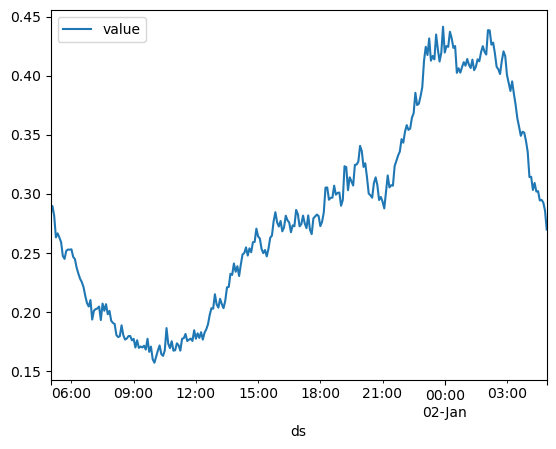

In [8]:
df = pd.read_csv(
    "/home/user/data/FrequencyDiffusion/dataset/MFRED_clean.csv",
    index_col=0,
    parse_dates=True,
)[["value"]]
df = df[:288]
df.plot()

MAD in Time

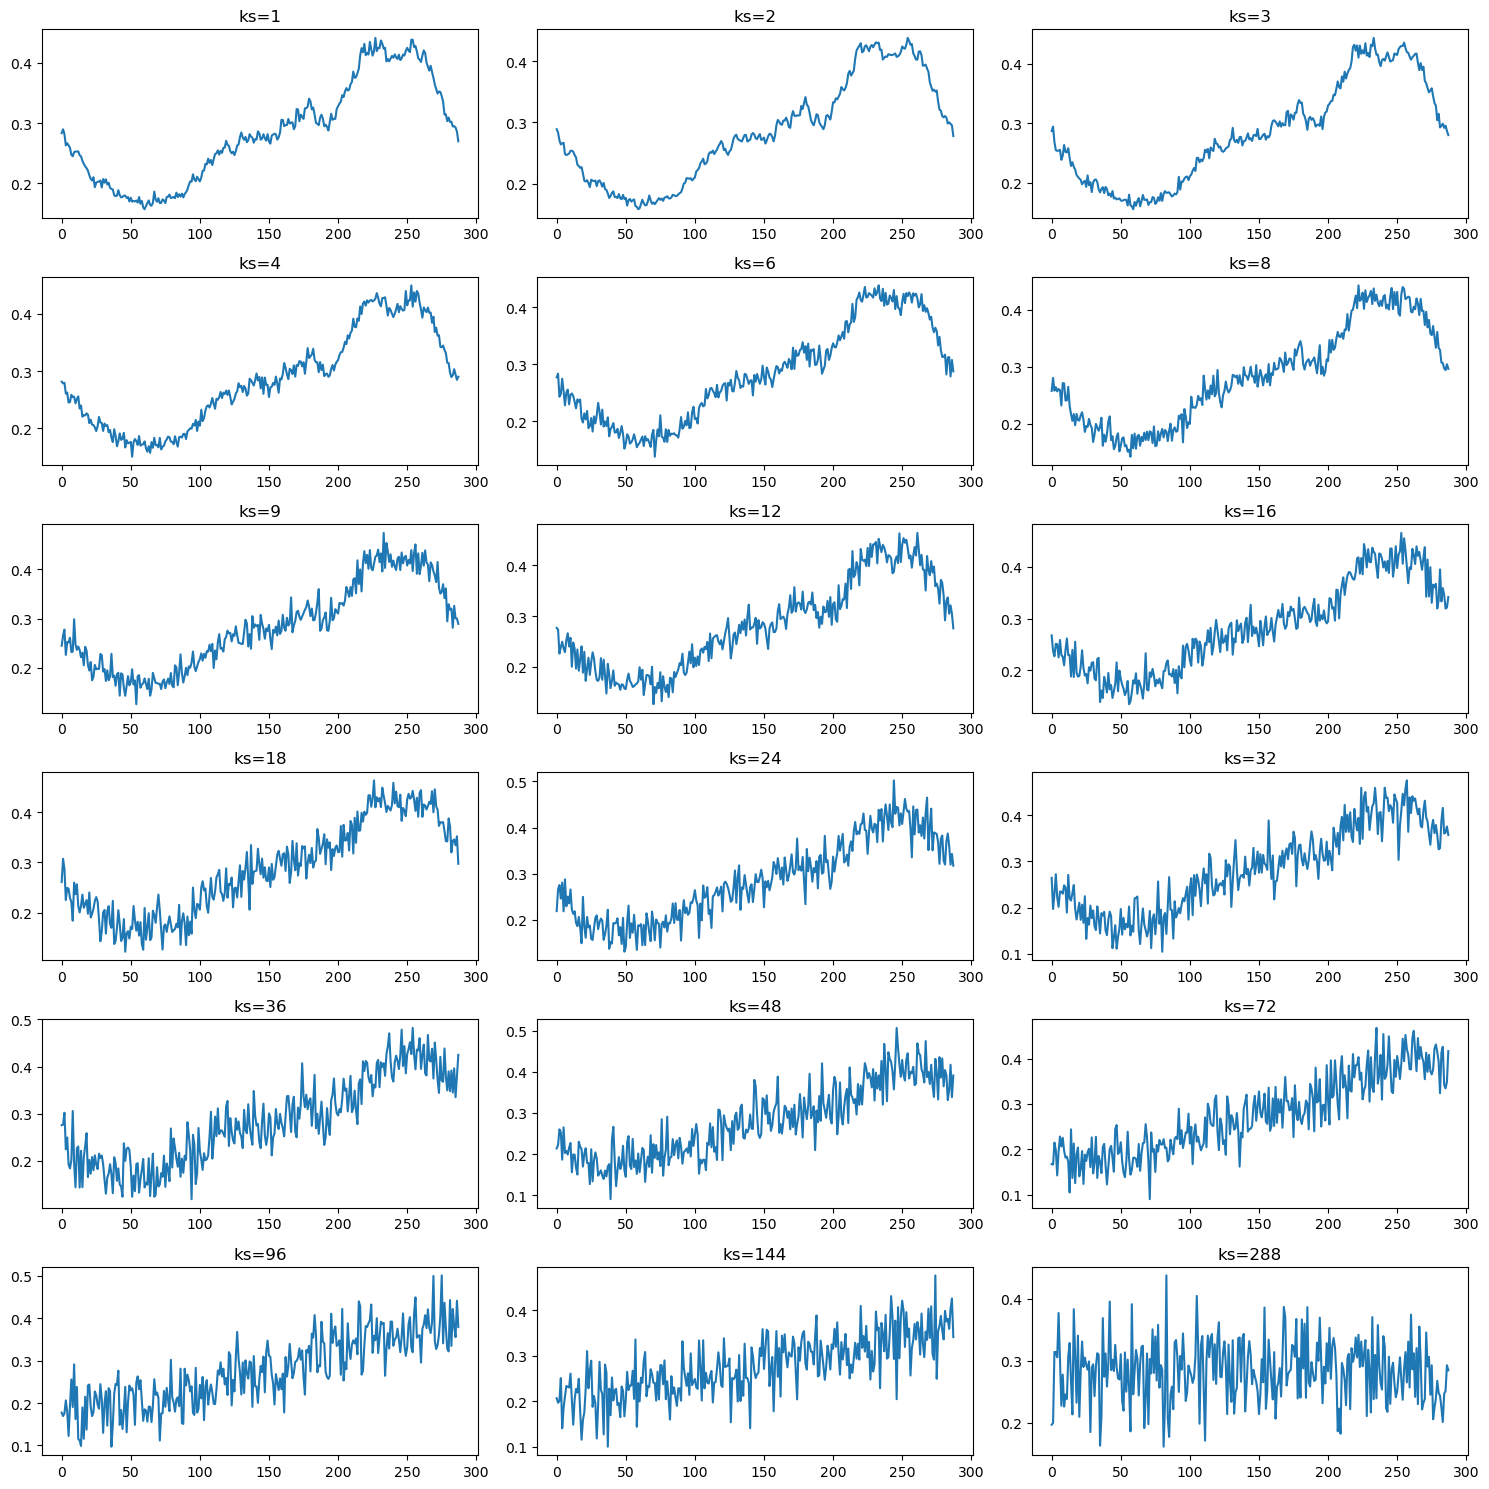

In [11]:
ks = [1]+get_factors(288) + [288]
fig, axs = plt.subplots(ceil(len(ks)/3), 3, figsize=(15, 15))
axs = axs.flatten()
for i, k in enumerate(ks):
    mat = MovingAvgTime(k)
    filtered_ = mat(torch.from_numpy(df.values).reshape(1,-1,1))
    # filtered_ = torch.nn.functional.interpolate(
    #             filtered_.permute(0, 2, 1),
    #             size=288 - k + 1, mode='nearest-exact'
    #         )[..., :: k]

    axs[i].plot(filtered_.flatten() + torch.randn_like(filtered_.flatten())*(i/len(ks)/20))
    axs[i].set_title(f'ks={k}')
fig.tight_layout()

MAD in Freq

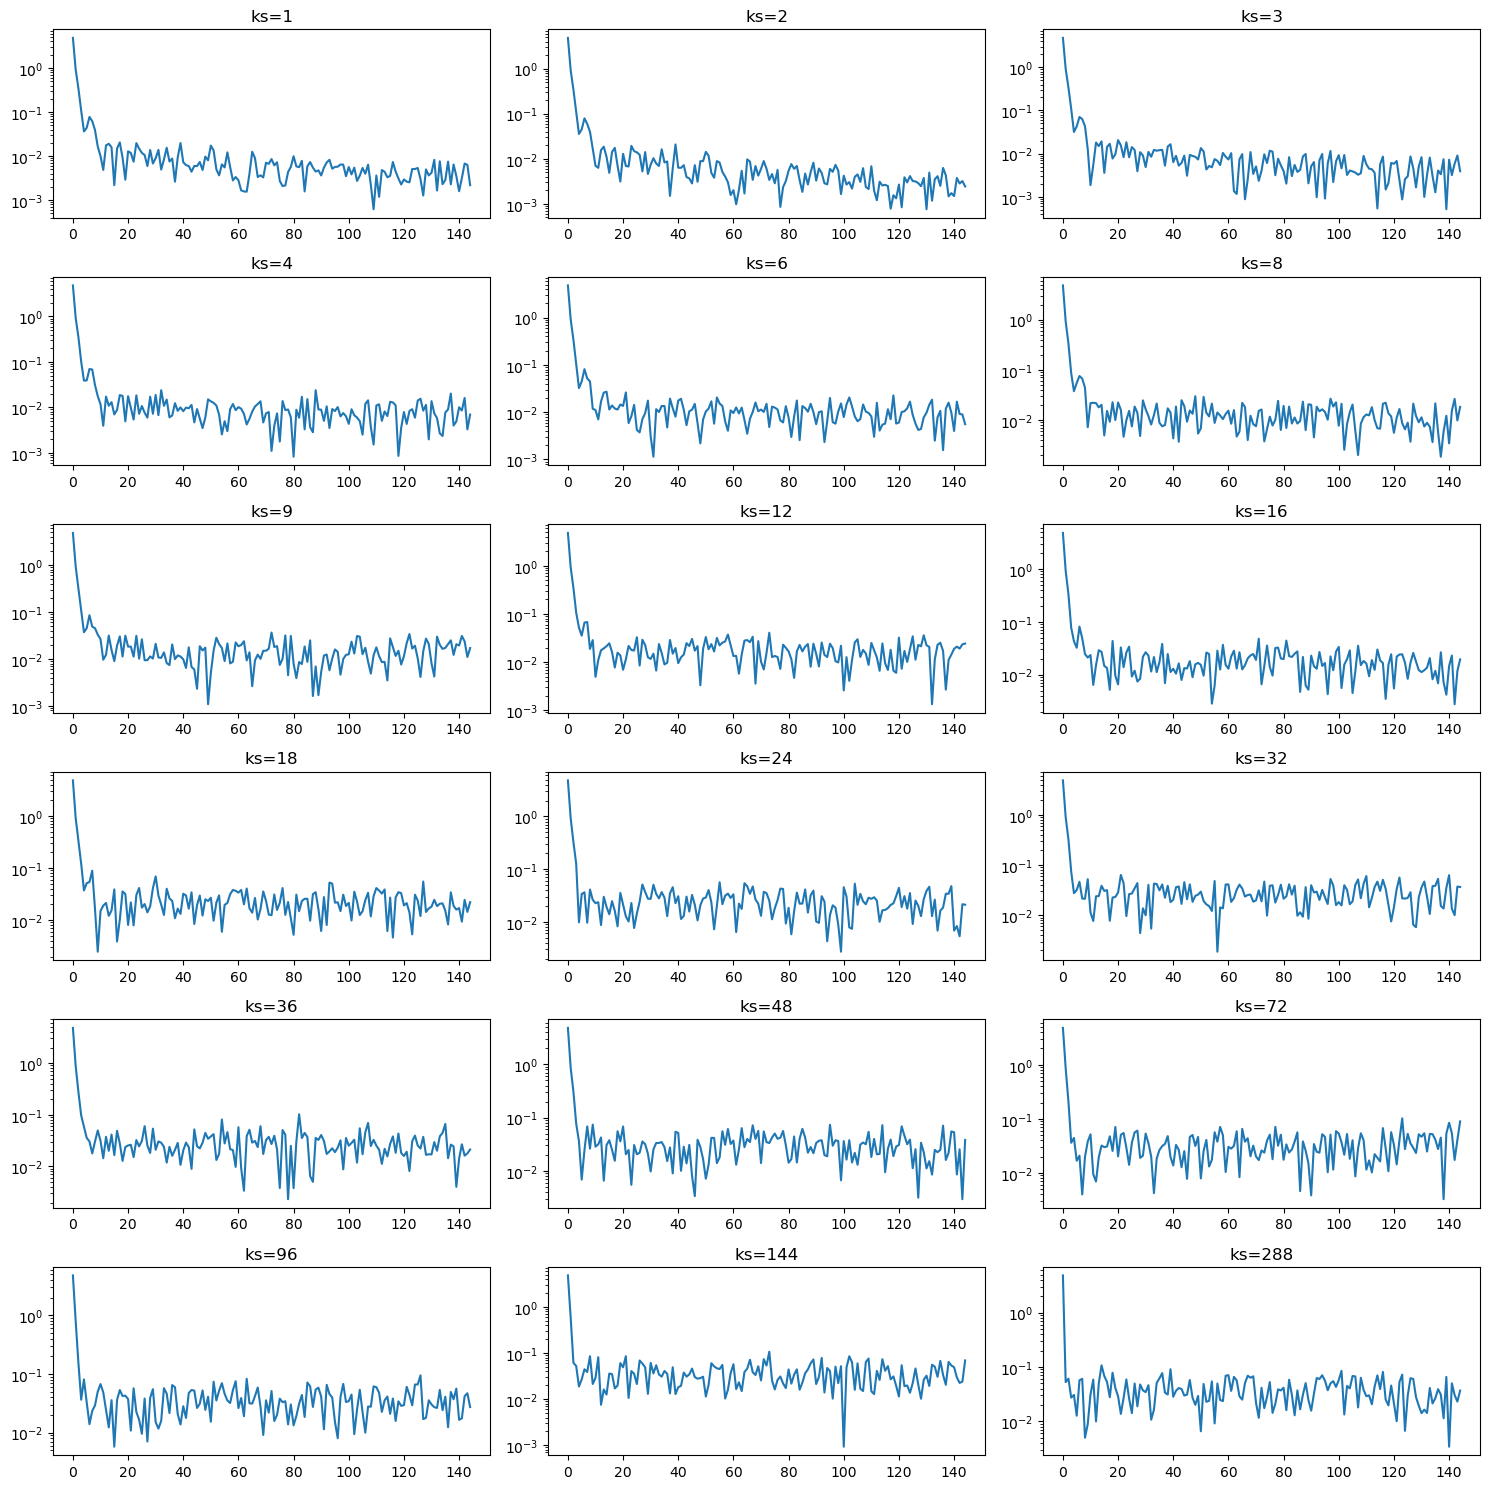

In [16]:
fig, axs = plt.subplots(ceil(len(ks)/3), 3, figsize=(15, 15))
axs = axs.flatten()
for i, k in enumerate(ks):
    maf = MovingAvgFreq(k, freq=torch.fft.rfftfreq(288))
    R = torch.diag(maf.Hw.flatten())
    df_fft = torch.from_numpy(df.values).reshape(1,-1,1)
    df_fft = torch.fft.rfft(df_fft, dim=1, norm='ortho')
    filtered_=maf(df_fft)
    filtered_ += torch.randn_like(filtered_) *(i/len(ks)/20)
    # df_ = torch.fft.irfft(filtered_, dim=1, norm='ortho')[:,k-1::k,:]
    axs[i].plot(filtered_.abs().flatten())
    axs[i].set_yscale('log')
    axs[i].set_title(f'ks={k}')
fig.tight_layout()

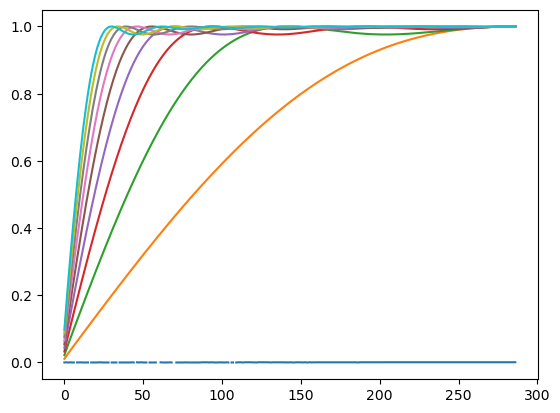

In [5]:
betas = []
ks = [i for i in range(2,289)]
for i, k in enumerate(ks):
    maf = MovingAvgFreq(k, freq=torch.fft.rfftfreq(288))
    R = torch.diag(maf.Hw.flatten())
    beta = torch.sqrt((1 - (R @ torch.conj(R).T).real).diag())
    betas.append(beta)
betas = torch.stack(betas)
plt.plot(betas[:,:10])